# Training a model on the ImageNet dataset

In [1]:
import os
import glob
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import albumentations as alb

from utils import *

gpus = tf.config.list_physical_devices('GPU')
tf.version.VERSION, gpus

('2.5.0', [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [2]:
# don't let TF allocate all GPU RAM, so we can check the amount actually being used
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
train_files = sorted(glob.glob('/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/*'))
valid_files = sorted(glob.glob('/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/*'))
len(train_files), len(valid_files)

(1024, 128)

In [4]:
image_shape = (224, 224)

def process_image(serialized_example, transforms):
    ''' decode and augment images '''
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    label = tf.cast(features['image/class/label'], tf.int64) - 1  # [0-999]
    
    image_aug = lambda img: transforms(image=img)["image"]
    aug_img = tf.numpy_function(func=image_aug, inp=[image], Tout=tf.float32)
    return aug_img, label

In [5]:
train_transforms = alb.Compose([
            alb.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30),
            alb.HorizontalFlip(p=0.5),
            alb.OneOf([ # Add or remove noise
                alb.GaussNoise(var_limit=(50, 200)),
                alb.ImageCompression(quality_lower=80, quality_upper=95),
                alb.GaussianBlur(sigma_limit=(2, 10)),
            ], p=1),
            alb.SomeOf([ # Color ops
                alb.ToGray(p=0.1),
                alb.Equalize(by_channels=False),
                alb.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
                alb.RandomGamma(gamma_limit=(90, 110)),
                alb.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10),
                alb.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.2, 0.2)),
            ], n=2),
            alb.RandomResizedCrop(*image_shape, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
            alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

valid_transforms = alb.Compose([
            alb.SmallestMaxSize(max_size=image_shape[0]),
            alb.CenterCrop(*image_shape),
            alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

In [6]:
epochs = 1
batch_size = 128
valid_samples, train_samples = 50000, 1281167
validation_steps = valid_samples // batch_size
steps_per_epoch = train_samples // batch_size

AUTO = tf.data.experimental.AUTOTUNE

def get_ds(tfrecords, transforms, batch_size, cache=False, shuffle_buffer=None):
    dataset = tf.data.TFRecordDataset(tfrecords)

    if cache:
        dataset = dataset.cache()

    if shuffle_buffer:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer,
                                  reshuffle_each_iteration=True)

    # decode and augment images
    decode_aug = lambda img: process_image(img, transforms)
    dataset = dataset.map(decode_aug, num_parallel_calls=AUTO)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTO)
    return dataset

valid_ds = get_ds(valid_files, valid_transforms, batch_size, cache=True)
train_ds = get_ds(train_files, train_transforms, batch_size, shuffle_buffer=1024)

In [7]:
# for images, labels in valid_ds.take(1):
#     print('Image shape:', images.shape, 'Labels:', labels.numpy())

# plot_grid(images[:6].numpy(), 'Sample images', rows=1, figsize=(16, 3))
# plt.show()

# pd.DataFrame(images.numpy().ravel()).describe().T

In [8]:
model = tf.keras.applications.ResNet50V2(include_top=True, classes=1000, weights=None)

# model.summary()

# w1 = model.weights[0].numpy()
# plot_grid(w1.transpose(3, 0, 1, 2), 'ImageNet kernels', figsize=(8.8, 9))
# w1.shape

In [9]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    alpha=0.01,
    decay_steps=steps_per_epoch*epochs
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.95)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="Top5")])

In [10]:
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(os.environ['SCRATCH'], 'imagenet_runs', datetime.now().strftime("%y%m%d-%H%M")),
    histogram_freq=1,
    update_freq=100, # batches
)

%reload_ext tensorboard
%tensorboard --logdir=imagenet_runs

In [11]:
fit = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_ds,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[tb_callback],
)

/apps/daint/UES/6.0.UP04/sandboxes/sarafael/mc-sumsch-2021/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


10009/10009 [==============================] - 5805s 579ms/step - loss: 4.9214 - accuracy: 0.1224 - Top5: 0.2705 - val_loss: 3.5226 - val_accuracy: 0.2763 - val_Top5: 0.5138


(7, 7, 3, 64)

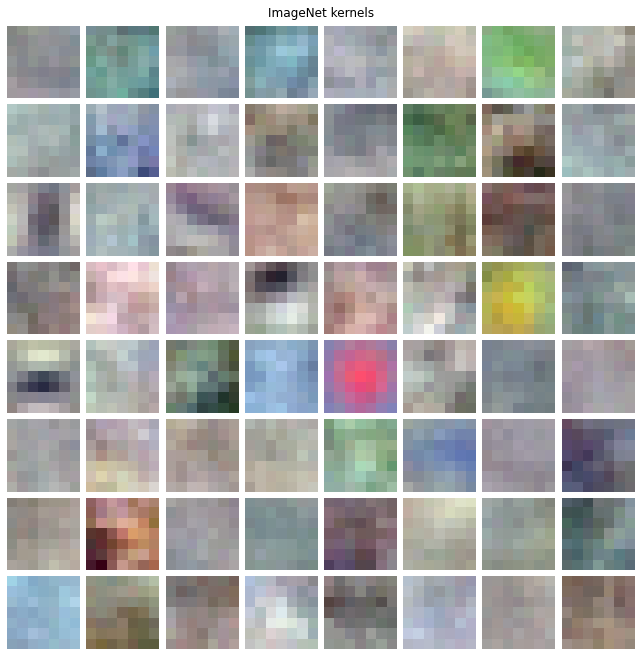

In [12]:
w1 = model.weights[0].numpy()
plot_grid(w1.transpose(3, 0, 1, 2), 'ImageNet kernels', figsize=(8.8, 9))
w1.shape